# Introduction

## Generative Adversarial Networks (GANs) on Fashion MNIST

Generative Adversarial Networks (GANs) have revolutionized the field of artificial intelligence by enabling the generation of realistic synthetic data. In this notebook, we will explore the application of GANs to the Fashion MNIST dataset, which consists of grayscale images of various clothing items such as shirts, pants, shoes, and more.

## Objectives

The main objectives of this notebook are:

1. **Understand GAN Architecture**: which consist of a generator and a discriminator. The generator aims to create realistic images, while the discriminator attempts to distinguish between real and generated images.
2. **Implement a GAN**: building and training the generator and discriminator networks.
3. **Train the GAN**: To train the GAN on the Fashion MNIST dataset. We will monitor the training process, including the losses of both the generator and discriminator, and adjust hyperparameters as necessary.
4. **Generate Fashion Images**: We will visualize and evaluate the quality of these synthetic images.
5. **Analyze Results**: To analyze the results and understand the strengths and limitations of our GAN model. We will discuss potential improvements and future directions for research.

## Dataset

The Fashion MNIST dataset is a large collection of 28x28 grayscale images, each labeled with one of ten categories representing different types of clothing and accessories. Each image is a low-resolution representation of a fashion item, making it a suitable challenge for a quick implementation of a generative model.

## Model
The model is built using tensoflow notably with LeakyReLU, Dropout,  BatchNormalization and Convolution layers

### Install required libs

In [1]:
# !pip install numpy
# !pip install scipy
# !pip install sklearn
# !pip install tensorflow-[gpu]
# !pip install tensorflow
# !pip install keras
# !pip install matplotlib


### Imports

In [6]:
import tensorflow as tf

from tensorflow.keras.layers import Dense, Input, LeakyReLU, Dropout,  BatchNormalization, Reshape, Flatten, Conv2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD

import numpy as np
import matplotlib.pyplot as plt
import sys,os

In [7]:
# We need to make sure we are using a GPU and not CPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


### Download datasets

In [4]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

x_train, x_test  = x_train / 255.0 * 2 -1, x_test / 255.0 * 2 -1,

In [ ]:
Y is the labels, as of the first version we will not use the labels in the training process but we will refactor the models to iclude a text input

In [5]:
y_train.shape

(60000,)

The fashion mnist dataset consists of 28x28 pixel images, Pretty low res

note we need to have datasets in the from of (28,28,1) for tensorflow to work with

In [6]:
x_train.shape

(60000, 28, 28)

Lets visualize some of the training data

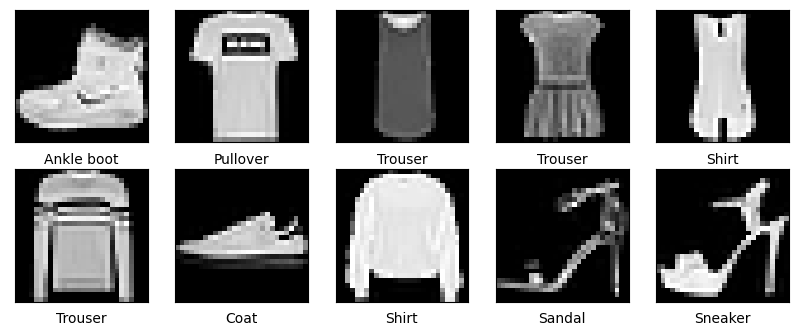

In [7]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

plt.figure(figsize=(10, 10))
for i in range(10):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap="gray")
    plt.xlabel(class_names[y_test[i]])
plt.show()


In [8]:
N, H, W = x_train.shape
D = H * W

x_train = x_train.reshape(-1,D)
x_test = x_test.reshape(-1,D)

In [9]:
latent_dim = 100

In [9]:
# New Generator / Discriminator models

def build_generator(latent_dim):
  i = Input(shape=(latent_dim,))
  x = Dense(256, activation=LeakyReLU(alpha=0.2))(i)
  x = BatchNormalization(momentum=0.8)(x)
  x = Dense(256, activation=LeakyReLU(alpha=0.2))(x)
  x = BatchNormalization(momentum=0.8)(x)
  x = Dense(256, activation=LeakyReLU(alpha=0.2))(x)
  x = BatchNormalization(momentum=0.8)(x)
  x = Dense(D, activation='tanh')(x)
  model = Model(i,x)
  return model

def build_discriminator(img_size):
    i = Input(shape=(img_size,))
    x = Reshape((28, 28, 1))(i)
    x = Conv2D(64, kernel_size=4, strides=2, padding='same', activation=LeakyReLU(alpha=0.2))(x)
    x = Dropout(0.25)(x)
    x = Conv2D(128, kernel_size=4, strides=2, padding='same', activation=LeakyReLU(alpha=0.2))(x)
    x = Dropout(0.25)(x)
    x = Conv2D(256, kernel_size=4, strides=2, padding='same', activation=LeakyReLU(alpha=0.2))(x)
    x = Dropout(0.25)(x)
    x = Flatten()(x)
    x = Dense(1, activation='sigmoid')(x)
    model = Model(i, x)
    return model

In [11]:
# Old Generator / Discriminator models
# I tried to work without convolution layers here at first and didnt quite like its performance
# I also decided to test out the sequential api, functional is much better IMO

# def build_generator(latent_dim):
#     model = Sequential([
#         Dense(256, input_shape=(latent_dim,)),
#         LeakyReLU(alpha=0.2),
#         BatchNormalization(),
#         Dense(512),
#         LeakyReLU(alpha=0.2),
#         BatchNormalization(),
#         Dense(1024),
#         LeakyReLU(alpha=0.2),
#         BatchNormalization(),
#         Dense(D, activation='tanh')
#     ])
#     return model

# def build_discriminator(img_size):
#     model = Sequential([
#         Dense(1024, input_shape=(img_size,)),
#         LeakyReLU(alpha=0.2),
#         Dropout(0.3),
#         Dense(512),
#         LeakyReLU(alpha=0.2),
#         Dropout(0.3),
#         Dense(256),
#         LeakyReLU(alpha=0.2),
#         Dropout(0.3),
#         Dense(1, activation='sigmoid')
#     ])
#     return model

We need to comile the generator and discrimitator and then combine the two into a model

In [15]:
# Discriminator - Model to tell if an image is real of AI
discriminator = build_discriminator(D)
discriminator.compile(
    loss='binary_crossentropy',
    optimizer=Adam(0.0002,0.5),
    metrics=['accuracy']
)

# Generator - Model the creates the Images
generator = build_generator(latent_dim)
z = Input(shape=(latent_dim,))
img = generator(z)
discriminator.trainable = False

fake_pred = discriminator(img)

combined_model = Model(z, fake_pred)

combined_model.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

2024-07-02 12:40:48.841857: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-02 12:40:48.860926: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-02 12:40:48.861566: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-02 12:40:48.862544: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate

In [16]:
# Clear the gan_images directory
!rm -rf gan_images


/bin/bash: /home/kip/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)


preparation for training

In [17]:
batch_size = 32
epochs = 10000
sample_period = 200

ones = np.ones(batch_size)
zeros = np.zeros(batch_size)

d_losses = []
g_losses = []

if not os.path.exists('gan_images'):
  os.makedirs('gan_images')

Considering we can run upto 50,000 epochs, we want to be able to see how the model is performing as it is in the trainin process.

One great way to do this is to save sample images during training

In [18]:
def sample_images(epoch):
  rows, cols = 5, 5
  noise = np.random.randn(rows * cols, latent_dim)
  imgs = generator.predict(noise)

  imgs = 0.5 * imgs + 0.5

  fig, axs = plt.subplots(rows, cols)
  idx = 0

  for i in range(rows):
    for j in range(cols):
      axs[i,j].imshow(imgs[idx].reshape(H,W),cmap='gray')
      axs[i,j].axis('off')
      idx += 1
    fig.savefig("gan_images/%d.png"%epoch)
    plt.close()

In [19]:
for epoch in range(epochs):
  # Select random real Images
  idx = np.random.randint(0, x_train.shape[0], batch_size)
  real_imgs = x_train[idx]

  # Genreate fake images
  noise = np.random.randn(batch_size, latent_dim)
  fake_imgs = generator.predict(noise)

  # model.train_on_batch is like one step in model.fit we train only on the images
  # we the test the discriminator on real images and fake images
  d_loss_real, d_acc_real = discriminator.train_on_batch(real_imgs, ones)
  d_loss_fake, d_acc_fake = discriminator.train_on_batch(fake_imgs, zeros)
  
  # Average the losses and accuracy 
  d_loss = 0.5 * (d_loss_real + d_loss_fake)
  d_acc = 0.5 * (d_acc_real + d_acc_fake)

  # train the generator
  noise = np.random.rand(batch_size, latent_dim)
  g_loss = combined_model.train_on_batch(noise, ones)
  
  # Keep the losses, accuracy in an array so we can visualize later
  d_losses.append(d_loss)
  g_losses.append(g_loss)
    
  # We want to save the images after every 100 training epochs
  if epoch % 100 == 0:
    print(f"epoch: {epoch+1}/{epochs}, d_loss: {d_loss: .2f}, \
    d_acc: {d_acc:.2f}, g_loss: {g_loss:.2f}")

  if epoch % sample_period == 0:
    sample_images(epoch)



1/1 [==============================] - 0s 418ms/step


2024-07-02 12:40:59.512945: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2024-07-02 12:40:59.843031: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-07-02 12:40:59.878934: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-07-02 12:40:59.879010: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2024-07-02 12:40:59.916827: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-07-02 12:40:59.916925: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


epoch: 1/10000, d_loss:  0.71,     d_acc: 0.11, g_loss: 0.67
1/1 [==============================] - 0s 15ms/step
epoch: 101/10000, d_loss:  0.00,     d_acc: 1.00, g_loss: 0.94
1/1 [==============================] - 0s 15ms/step
epoch: 201/10000, d_loss:  0.00,     d_acc: 1.00, g_loss: 0.79
1/1 [==============================] - 0s 15ms/step
epoch: 301/10000, d_loss:  0.01,     d_acc: 1.00, g_loss: 0.35
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step
epoch: 401/10000, d_loss:  0.13,     d_acc: 0.97, g_loss: 0.14
1/1 [==============================] - 0s 15ms/step
epoch: 501/10000, d_loss:  0.08,     d_acc: 0.97, g_loss: 0.04
1/1 [==============================] - 0s 15ms/step
epoch: 601/10000, d_loss:  0.18,     d_acc: 0.95, g_loss: 0.02
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step
epoch: 701/10000, d_loss:  0.03,     d_acc: 0.98, g_loss: 0.01
1/1 [==============================] - 0s 16ms/step
epoch: 801/10000, d_loss:  0.01,     d_acc: 1.00, g_loss: 0.01
1/1 [==============================] - 0s 15ms/step
epoch: 901/10000, d_loss:  0.12,     d_acc: 0.97, g_loss: 0.00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 15ms/step
epoch: 1001/10000, d_loss:  0.04,     d_acc: 0.98, g_loss: 0.00
1/1 [==============================] - 0s 20ms/step
epoch: 1101/10000, d_loss:  0.01,     d_acc: 1.00, g_loss: 0.01
1/1 [==============================] - 0s 17ms/step
epoch: 1201/10000, d_loss:  0.01,     d_acc: 1.00, g_loss: 0.00
1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 15ms/step
epoch: 1301/10000, d_loss:  0.01,     d_acc: 1.00, g_loss: 0.00
1/1 [==============================] - 0s 17ms/step
epoch: 1401/10000, d_loss:  0.00,     d_acc: 1.00, g_loss: 0.00
1/1 [==============================] - 0s 16ms/step
epoch: 1501/10000, d_loss:  0.00,     d_acc: 1.00, g_loss: 0.00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step
epoch: 1601/10000, d_loss:  1.10,     d_acc: 0.70, g_loss: 0.07
1/1 [==============================] - 0s 17ms/step
epoch: 1701/10000, d_loss:  0.09,     d_acc: 0.97, g_loss: 0.01
1/1 [==============================] - 0s 15ms/step
epoch: 1801/10000, d_loss:  0.01,     d_acc: 1.00, g_loss: 0.01
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step
epoch: 1901/10000, d_loss:  0.01,     d_acc: 1.00, g_loss: 0.00
1/1 [==============================] - 0s 16ms/step
epoch: 2001/10000, d_loss:  0.01,     d_acc: 1.00, g_loss: 0.01
1/1 [==============================] - 0s 15ms/step
epoch: 2101/10000, d_loss:  0.01,     d_acc: 1.00, g_loss: 0.00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 17ms/step
epoch: 2201/10000, d_loss:  0.00,     d_acc: 1.00, g_loss: 0.00
1/1 [==============================] - 0s 17ms/step
epoch: 2301/10000, d_loss:  0.00,     d_acc: 1.00, g_loss: 0.00
1/1 [==============================] - 0s 20ms/step
epoch: 2401/10000, d_loss:  0.00,     d_acc: 1.00, g_loss: 0.00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
epoch: 2501/10000, d_loss:  0.00,     d_acc: 1.00, g_loss: 0.00
1/1 [==============================] - 0s 15ms/step
epoch: 2601/10000, d_loss:  0.00,     d_acc: 1.00, g_loss: 0.00
1/1 [==============================] - 0s 17ms/step
epoch: 2701/10000, d_loss:  0.01,     d_acc: 1.00, g_loss: 0.00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
epoch: 2801/10000, d_loss:  0.00,     d_acc: 1.00, g_loss: 0.00
1/1 [==============================] - 0s 18ms/step
epoch: 2901/10000, d_loss:  0.01,     d_acc: 1.00, g_loss: 0.00
1/1 [==============================] - 0s 17ms/step
epoch: 3001/10000, d_loss:  0.01,     d_acc: 1.00, g_loss: 0.00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step
epoch: 3101/10000, d_loss:  0.01,     d_acc: 1.00, g_loss: 0.00
1/1 [==============================] - 0s 17ms/step
epoch: 3201/10000, d_loss:  0.25,     d_acc: 0.97, g_loss: 0.02
1/1 [==============================] - 0s 16ms/step
epoch: 3301/10000, d_loss:  0.01,     d_acc: 1.00, g_loss: 0.02
1/1 [==============================] - 0s 16ms/step
epoch: 3401/10000, d_loss:  0.02,     d_acc: 1.00, g_loss: 0.01
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 18ms/step
epoch: 3501/10000, d_loss:  0.12,     d_acc: 0.95, g_loss: 0.00
1/1 [==============================] - 0s 15ms/step
epoch: 3601/10000, d_loss:  0.03,     d_acc: 1.00, g_loss: 0.00
1/1 [==============================] - 0s 18ms/step
epoch: 3701/10000, d_loss:  0.01,     d_acc: 1.00, g_loss: 0.01
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 16ms/step
epoch: 3801/10000, d_loss:  0.01,     d_acc: 1.00, g_loss: 0.00
1/1 [==============================] - 0s 15ms/step
epoch: 3901/10000, d_loss:  0.02,     d_acc: 1.00, g_loss: 0.00
1/1 [==============================] - 0s 15ms/step
epoch: 4001/10000, d_loss:  0.05,     d_acc: 0.98, g_loss: 0.02
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 18ms/step
epoch: 4101/10000, d_loss:  0.04,     d_acc: 1.00, g_loss: 0.27
1/1 [==============================] - 0s 16ms/step
epoch: 4201/10000, d_loss:  0.08,     d_acc: 0.98, g_loss: 0.05
1/1 [==============================] - 0s 15ms/step
epoch: 4301/10000, d_loss:  0.03,     d_acc: 0.98, g_loss: 0.02
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step
epoch: 4401/10000, d_loss:  0.07,     d_acc: 0.97, g_loss: 0.02
1/1 [==============================] - 0s 18ms/step
epoch: 4501/10000, d_loss:  0.04,     d_acc: 0.98, g_loss: 0.01
1/1 [==============================] - 0s 16ms/step
epoch: 4601/10000, d_loss:  0.03,     d_acc: 1.00, g_loss: 0.01
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step
epoch: 4701/10000, d_loss:  0.02,     d_acc: 1.00, g_loss: 0.04
1/1 [==============================] - 0s 16ms/step
epoch: 4801/10000, d_loss:  0.08,     d_acc: 0.97, g_loss: 0.04
1/1 [==============================] - 0s 17ms/step
epoch: 4901/10000, d_loss:  0.15,     d_acc: 0.97, g_loss: 0.01
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 16ms/step
epoch: 5001/10000, d_loss:  0.05,     d_acc: 1.00, g_loss: 0.08
1/1 [==============================] - 0s 15ms/step
epoch: 5101/10000, d_loss:  0.13,     d_acc: 0.95, g_loss: 0.03
1/1 [==============================] - 0s 15ms/step
epoch: 5201/10000, d_loss:  0.19,     d_acc: 0.94, g_loss: 0.31
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 16ms/step
epoch: 5301/10000, d_loss:  0.08,     d_acc: 0.97, g_loss: 0.05
1/1 [==============================] - 0s 15ms/step
epoch: 5401/10000, d_loss:  0.16,     d_acc: 0.94, g_loss: 0.18
1/1 [==============================] - 0s 16ms/step
epoch: 5501/10000, d_loss:  0.14,     d_acc: 0.95, g_loss: 0.32
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step
epoch: 5601/10000, d_loss:  0.07,     d_acc: 0.98, g_loss: 0.31
1/1 [==============================] - 0s 16ms/step
epoch: 5701/10000, d_loss:  0.04,     d_acc: 1.00, g_loss: 0.10
1/1 [==============================] - 0s 18ms/step
epoch: 5801/10000, d_loss:  0.02,     d_acc: 1.00, g_loss: 0.74
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 19ms/step
epoch: 5901/10000, d_loss:  0.10,     d_acc: 0.95, g_loss: 0.37
1/1 [==============================] - 0s 18ms/step
epoch: 6001/10000, d_loss:  0.11,     d_acc: 0.97, g_loss: 0.29
1/1 [==============================] - 0s 15ms/step
epoch: 6101/10000, d_loss:  0.06,     d_acc: 0.98, g_loss: 0.30
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step
epoch: 6201/10000, d_loss:  0.19,     d_acc: 0.95, g_loss: 0.17
1/1 [==============================] - 0s 17ms/step
epoch: 6301/10000, d_loss:  0.08,     d_acc: 0.97, g_loss: 0.85
1/1 [==============================] - 0s 19ms/step
epoch: 6401/10000, d_loss:  0.05,     d_acc: 0.98, g_loss: 0.94
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 15ms/step
epoch: 6501/10000, d_loss:  0.11,     d_acc: 0.97, g_loss: 0.25
1/1 [==============================] - 0s 16ms/step
epoch: 6601/10000, d_loss:  0.06,     d_acc: 0.98, g_loss: 1.13
1/1 [==============================] - 0s 16ms/step
epoch: 6701/10000, d_loss:  0.06,     d_acc: 0.98, g_loss: 0.65
1/1 [==============================] - 0s 16ms/step
epoch: 6801/10000, d_loss:  0.04,     d_acc: 1.00, g_loss: 0.51
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step
epoch: 6901/10000, d_loss:  0.03,     d_acc: 1.00, g_loss: 0.64
1/1 [==============================] - 0s 14ms/step
epoch: 7001/10000, d_loss:  0.05,     d_acc: 0.98, g_loss: 0.86
1/1 [==============================] - 0s 15ms/step
epoch: 7101/10000, d_loss:  0.05,     d_acc: 0.98, g_loss: 1.08
1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 15ms/step
epoch: 7201/10000, d_loss:  0.08,     d_acc: 0.97, g_loss: 1.55
1/1 [==============================] - 0s 17ms/step
epoch: 7301/10000, d_loss:  0.19,     d_acc: 0.94, g_loss: 0.64
1/1 [==============================] - 0s 16ms/step
epoch: 7401/10000, d_loss:  0.03,     d_acc: 0.98, g_loss: 1.20
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step
epoch: 7501/10000, d_loss:  0.01,     d_acc: 1.00, g_loss: 1.08
1/1 [==============================] - 0s 16ms/step
epoch: 7601/10000, d_loss:  0.03,     d_acc: 1.00, g_loss: 0.65
1/1 [==============================] - 0s 14ms/step
epoch: 7701/10000, d_loss:  0.03,     d_acc: 1.00, g_loss: 0.74
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 15ms/step
epoch: 7801/10000, d_loss:  0.17,     d_acc: 0.91, g_loss: 1.17
1/1 [==============================] - 0s 17ms/step
epoch: 7901/10000, d_loss:  0.08,     d_acc: 0.97, g_loss: 1.02
1/1 [==============================] - 0s 19ms/step
epoch: 8001/10000, d_loss:  0.14,     d_acc: 0.94, g_loss: 0.75
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 15ms/step
epoch: 8101/10000, d_loss:  0.02,     d_acc: 1.00, g_loss: 1.11
1/1 [==============================] - 0s 15ms/step
epoch: 8201/10000, d_loss:  0.01,     d_acc: 1.00, g_loss: 0.93
1/1 [==============================] - 0s 16ms/step
epoch: 8301/10000, d_loss:  0.01,     d_acc: 1.00, g_loss: 1.07
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 20ms/step
epoch: 8401/10000, d_loss:  0.02,     d_acc: 1.00, g_loss: 0.78
1/1 [==============================] - 0s 16ms/step
epoch: 8501/10000, d_loss:  0.04,     d_acc: 1.00, g_loss: 0.29
1/1 [==============================] - 0s 15ms/step
epoch: 8601/10000, d_loss:  0.06,     d_acc: 0.98, g_loss: 0.44
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 21ms/step
epoch: 8701/10000, d_loss:  0.03,     d_acc: 1.00, g_loss: 0.46
1/1 [==============================] - 0s 17ms/step
epoch: 8801/10000, d_loss:  0.03,     d_acc: 1.00, g_loss: 0.42
1/1 [==============================] - 0s 14ms/step
epoch: 8901/10000, d_loss:  0.01,     d_acc: 1.00, g_loss: 0.54
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 15ms/step
epoch: 9001/10000, d_loss:  0.02,     d_acc: 1.00, g_loss: 0.96
1/1 [==============================] - 0s 17ms/step
epoch: 9101/10000, d_loss:  0.01,     d_acc: 1.00, g_loss: 0.62
1/1 [==============================] - 0s 15ms/step
epoch: 9201/10000, d_loss:  0.06,     d_acc: 0.97, g_loss: 0.69
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step
epoch: 9301/10000, d_loss:  0.02,     d_acc: 0.98, g_loss: 1.57
1/1 [==============================] - 0s 15ms/step
epoch: 9401/10000, d_loss:  0.02,     d_acc: 1.00, g_loss: 1.91
1/1 [==============================] - 0s 16ms/step
epoch: 9501/10000, d_loss:  0.03,     d_acc: 0.98, g_loss: 2.11
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 15ms/step
epoch: 9601/10000, d_loss:  0.05,     d_acc: 0.98, g_loss: 2.07
1/1 [==============================] - 0s 15ms/step
epoch: 9701/10000, d_loss:  0.01,     d_acc: 1.00, g_loss: 0.95
1/1 [==============================] - 0s 16ms/step
epoch: 9801/10000, d_loss:  0.04,     d_acc: 0.98, g_loss: 0.43
1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 15ms/step
epoch: 9901/10000, d_loss:  0.08,     d_acc: 0.95, g_loss: 0.82
1/1 [==============================] - 0s 15ms/step


If this model works well, we do not want to see the losses diverge, the should be close.

We want the discriminator loss to increase alittle as this would mean it is having difficulty differentiating the real from fake images.

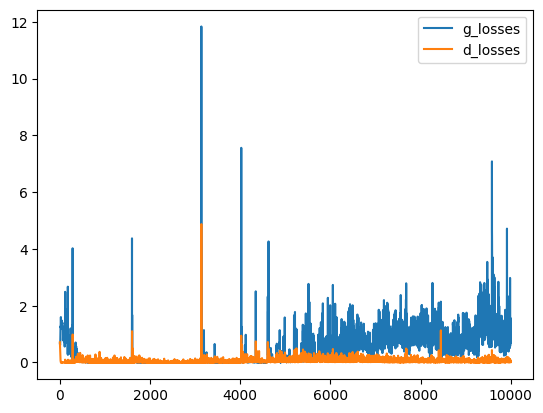

In [20]:
plt.plot(g_losses, label='g_losses')
plt.plot(d_losses, label='d_losses')
plt.legend()

The model still has lots of space to improve, I only ran it for 10,000 epochs (25 minutes). In future I will run it for 30,000-50,000 

In [21]:
!ls gan_images

/bin/bash: /home/kip/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
0.png	  2000.png  3400.png  4600.png	600.png   7200.png  8400.png  9800.png
1000.png  2200.png  3600.png  4800.png	6000.png  7400.png  8600.png
1200.png  2400.png  3800.png  5000.png	6200.png  7600.png  8800.png
1400.png  2600.png  400.png   5200.png	6400.png  7800.png  9000.png
1600.png  2800.png  4000.png  5400.png	6600.png  800.png   9200.png
1800.png  3000.png  4200.png  5600.png	6800.png  8000.png  9400.png
200.png   3200.png  4400.png  5800.png	7000.png  8200.png  9600.png


Lets run a predictions with the generator

1/1 [==============================] - 0s 24ms/step


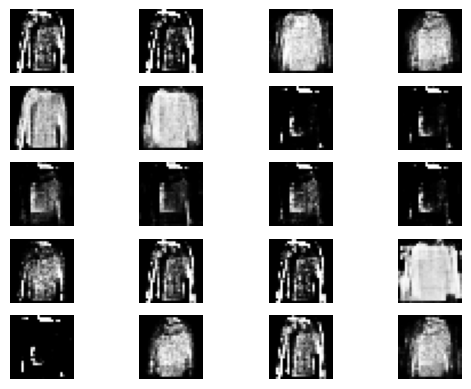

In [22]:
rows, cols = 5, 4
noise = np.random.randn(rows * cols, latent_dim)
imgs = generator.predict(noise)

imgs = 0.5 * imgs + 0.5

fig, axs = plt.subplots(rows, cols)
idx = 0

for i in range(rows):
    for j in range(cols):
        axs[i,j].imshow(imgs[idx].reshape(H,W),cmap='gray')
        axs[i,j].axis('off')
        idx += 1
plt.show()


# Future Works

1. Train on 50,000 epochs
2. Add text prompts